In [1]:
import numpy as onp
import jax.numpy as np
from jax import random
from jax import jit
from jax_md.util import *
import matplotlib.pyplot as plt
key = random.PRNGKey(0)
from jax_md import quantity, energy

from jax_pd import space, materials, damage, mesh, plots, solvers, util, simulation


/Users/ravinderbhattoo/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:120: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [45]:
displacement_fn, shift_fn = space.free()

R = np.array([[i,j,k] for i in range(10) for j in range(5) for k in range(5)],dtype=np.float32)

box_size = [10,9,9]
cutoff = f32(2.5)
bonds0 = util.bonds(displacement_fn, box_size, cutoff, R)

lengths0 = util.bond_lengths(bonds0,R)

/Users/ravinderbhattoo/anaconda3/lib/python3.7/site-packages/jax/lax/lax.py:4599: UserWarning: Explicitly requested dtype <class 'numpy.int64'> requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/Users/ravinderbhattoo/anaconda3/lib/python3.7/site-packages/jax/lax/lax.py:4599: UserWarning: Explicitly requested dtype <class 'numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/Users/ravinderbhattoo/anaconda3/lib/python3.7/site-packages/jax/lax/lax.py:4599: 

In [46]:
stretch = f32(0.4)
epsilon = f32(1000)
epsilon2 = f32(1000)
radius = f32(1)

energy_fn = [{'func':materials.simple_spring_bond,
              'args':[displacement_fn], 
              'kwargs':dict(bond=bonds0,length=lengths0, epsilon=epsilon, stretch=stretch, 
                            radius=radius, epsilon2=epsilon2)
                 }, 
            {'func':energy.soft_sphere_pair, 
             'args':[displacement_fn], 
             'kwargs':dict(sigma=radius, epsilon=epsilon2)
                },
                [bonds0,stretch]]

def cal_energy(R,energy_fn):
    energy_fn_calable = [i['func'](*i['args'],**i['kwargs']) for i in energy_fn[:-1]]
    return np.sum([j(R) for j in energy_fn_calable])

cal_energy(R,energy_fn)

DeviceArray(0., dtype=float32)

In [47]:
def move(R,bool,t=0,R0=R,v=np.array([[0.01,0,0]])):
    return R0[bool,:]+t*v

def fix(R,bool,t=0,R0=R):
    return R0[bool,:]


Rbc = [{'bool':R[:,0]<2.5,'fn':move,'kwargs':{'R0':R,'v':np.array([[-0.001,0,0]])}},
       {'bool':R[:,0]>6.5,'fn':move,'kwargs':{'R0':R,'v':np.array([[0.001,0,0]])}},
              ]
 

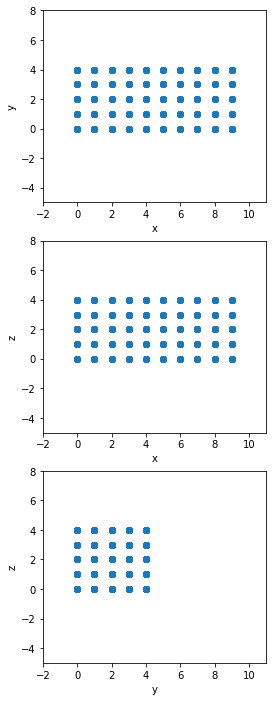

In [48]:
R1 = [R]

def Plotit(i):
    x,y = 1,3
    fig, axs = plt.subplots(y,x,figsize=[4*x,4*y])
    labels = [['x','y'],['x','z'],['y','z']]
    for ax,label in zip(axs,labels):
        ax.set_xlim([-2, 11])
        ax.set_ylim([-5, 8])
        ax.set_xlabel(label[0])
        ax.set_ylabel(label[1])
        ax.axis('on')

    plots.W3(i,R1,axs)
    plt.show()

Plotit(0)


In [49]:
runs = 2000

info = [[],[],[]]
simulation.run(info,key,runs,1.0e-3, R,energy_fn,shift_fn,Rbc=Rbc,mass=1.0,print_every=50,value_every=3,pos_every=1)


Initial conditions(after iBC): 
KE: 0.000000, PE: 0.000, TE: 0.000
Initial conditions(after BC): 
KE: 0.000000, PE: 0.000, TE: 0.000
Run # 0 :  KE: 0.000000, PE: 0.000, TE: 0.000
Run # 50 :  KE: 1367.505737, PE: 595.957, TE: 1963.462
Run # 100 :  KE: 17165.220703, PE: 2432.495, TE: 19597.715
Run # 150 :  KE: 71872.992188, PE: 5629.819, TE: 77502.812
Run # 200 :  KE: 194291.687500, PE: 10345.822, TE: 204637.516
Run # 250 :  KE: 415786.593750, PE: 16683.984, TE: 432470.562
Run # 300 :  KE: 767726.687500, PE: 24819.428, TE: 792546.125
Run # 350 :  KE: 1281602.500000, PE: 34851.707, TE: 1316454.250
Run # 400 :  KE: 1986185.125000, PE: 46970.957, TE: 2033156.125
Run # 450 :  KE: 2908637.750000, PE: 61169.578, TE: 2969807.250
Run # 500 :  KE: 4074679.750000, PE: 77719.531, TE: 4152399.250
Run # 550 :  KE: 5486480.000000, PE: 93115.445, TE: 5579595.500
Run # 600 :  KE: 7163165.000000, PE: 113425.711, TE: 7276590.500
Run # 650 :  KE: 9139704.000000, PE: 136280.328, TE: 9275984.000
Run # 700 : 

True

In [50]:
positions, states, state_values = info

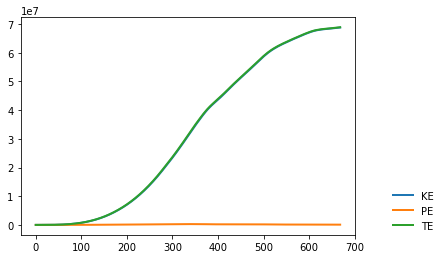

In [51]:
plt.plot(range(len(state_values)),np.array(state_values),lw=2)
plt.legend(['KE','PE','TE'],frameon=False,loc=[1.1,0])

In [52]:
F1 = []
F2 = []
mask1 = Rbc[0]['bool']
mask2 = Rbc[1]['bool']

F1 += [(state.acceleration*state.mass)[mask1,0].sum() for state in states]
F2 += [(state.acceleration*state.mass)[mask2,0].sum() for state in states]
    

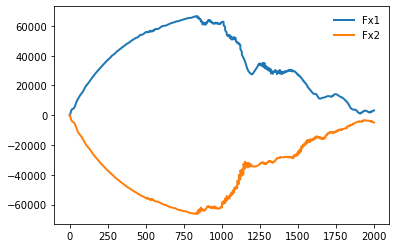

In [53]:
plt.plot(range(len(F1)),F1,label='Fx1',lw=2)
plt.plot(range(len(F2)),F2,label='Fx2',lw=2)
plt.legend(frameon=0)

In [ ]:
from IPython.display import display

import matplotlib
k = 50
ms = 5


def myplot(i):
    global ax,l,k
    i = i*k
    R_plt = onp.array(positions[i])
    ls[0].set_data(R_plt[:, 0], R_plt[:, 1],) 
    ls[1].set_data(R_plt[:, 0], R_plt[:, 2],) 
    ls[2].set_data(R_plt[:, 1], R_plt[:, 2],) 
    ls[3].set_data(np.linspace(0,10,len(F1))[:i],np.array(F1)[:i]/max(F1)*10+5)


fig, axs = plt.subplots(1,3,figsize=[12,4])
ls = []
for ax in axs:
    ls.append(ax.plot([],[],'o', markersize=ms)[0])
    ax.set_xlim([-10, 20])
    ax.set_ylim([-10, 20])
    ax.axis('on')
ls.append(axs[0].plot([],[],)[0])


from matplotlib.animation import FuncAnimation
ani = FuncAnimation(fig, myplot, frames=int(len(positions)/k))

from IPython.display import HTML
_ = HTML(ani.to_jshtml())


In [ ]:
display(_)